In [ ]:
import pandas as pd
from operator import attrgetter
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import numpy as np

In [ ]:
data = pd.read_csv('task 3.csv', index_col=0)

In [ ]:
data.head()

,dlk_cob_date,user_id
0,2023-08-22,a95b0e7e-deda-4cb8-81d2-cff4a01e9077
1,2023-06-12,4f53a875-847f-47cb-ab16-3517ca9cf92c
2,2024-08-15,f04fb972-ff9c-41ce-8dbc-a0984e6017ae
3,2023-12-08,1d9bcb51-351d-4679-8aba-95f38b9c56e9
4,2024-10-15,21d807eb-1ae4-4061-a403-96b5eefdd312


In [ ]:
data['dlk_cob_date'] = pd.to_datetime(data['dlk_cob_date'])

In [ ]:
# Создаем копию данных, чтобы избежать изменений в исходном DataFrame
data_copy = data.copy()

In [ ]:
# Извлекаем месяц и день заказа
data_copy['order_period'] = data_copy['dlk_cob_date'].dt.to_period('M')
data_copy['order_period_day'] = data_copy['dlk_cob_date'].dt.to_period('D')

In [ ]:
# Присваиваем когорты на основе даты первого действия для каждого пользователя
data_copy['cohort'] = data_copy.groupby('user_id')['dlk_cob_date'].transform('min').dt.to_period('M')
data_copy['cohort_day'] = data_copy.groupby('user_id')['dlk_cob_date'].transform('min').dt.to_period('D')

In [ ]:
# Рассчитываем номер периода в днях (месячные периоды, деля на 30)
data_copy['period_number_month'] = np.floor((data_copy.order_period_day - data_copy.cohort_day).apply(attrgetter('n')) / 30)

In [ ]:
data_copy.head()

,dlk_cob_date,user_id,order_period,order_period_day,cohort,cohort_day,period_number_month
0,2023-08-22,a95b0e7e-deda-4cb8-81d2-cff4a01e9077,2023-08,2023-08-22,2023-03,2023-03-31,4.0
1,2023-06-12,4f53a875-847f-47cb-ab16-3517ca9cf92c,2023-06,2023-06-12,2023-04,2023-04-04,2.0
2,2024-08-15,f04fb972-ff9c-41ce-8dbc-a0984e6017ae,2024-08,2024-08-15,2023-12,2023-12-04,8.0
3,2023-12-08,1d9bcb51-351d-4679-8aba-95f38b9c56e9,2023-12,2023-12-08,2023-07,2023-07-28,4.0
4,2024-10-15,21d807eb-1ae4-4061-a403-96b5eefdd312,2024-10,2024-10-15,2023-04,2023-04-10,18.0


In [ ]:
# Агрегируем данные по когортам и рассчитанному номеру периода (в месяцах)
df_cohort = data_copy.groupby(['cohort', 'period_number_month']).agg(n_customers=('user_id', 'nunique')).reset_index()

In [ ]:
df_cohort.head()

,cohort,period_number_month,n_customers
0,2023-01,0.0,162
1,2023-01,1.0,81
2,2023-01,2.0,90
3,2023-01,3.0,77
4,2023-01,4.0,69


In [ ]:
# Создаем сводную таблицу для когортного анализа
cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number_month', values='n_customers')

In [ ]:
cohort_pivot.head()

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2023-01,162.0,81.0,90.0,77.0,69.0,70.0,67.0,71.0,68.0,64.0,...,53.0,46.0,51.0,50.0,47.0,51.0,44.0,39.0,39.0,25.0
2023-02,138.0,49.0,48.0,45.0,44.0,41.0,38.0,33.0,43.0,41.0,...,42.0,35.0,39.0,37.0,30.0,33.0,35.0,27.0,17.0,NaN
2023-03,301.0,114.0,104.0,97.0,86.0,83.0,74.0,78.0,81.0,79.0,...,73.0,80.0,78.0,73.0,79.0,75.0,71.0,24.0,NaN,NaN
2023-04,591.0,213.0,178.0,179.0,172.0,169.0,178.0,146.0,137.0,135.0,...,138.0,135.0,132.0,128.0,119.0,116.0,94.0,NaN,NaN,NaN
2023-05,480.0,178.0,162.0,143.0,123.0,130.0,111.0,104.0,89.0,96.0,...,91.0,92.0,94.0,91.0,72.0,53.0,NaN,NaN,NaN,NaN


In [ ]:
# Рассчитываем размеры когорт (первый столбец сводной таблицы)
cohort_size = cohort_pivot.iloc[:, 0]

In [ ]:
# Вычисляем коэффициенты удержания, деля на размер когорты
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

In [ ]:
retention_matrix.head()

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2023-01,1.0,0.500000,0.555556,0.475309,0.425926,0.432099,0.413580,0.438272,0.419753,0.395062,...,0.327160,0.283951,0.314815,0.308642,0.290123,0.314815,0.271605,0.240741,0.240741,0.154321
2023-02,1.0,0.355072,0.347826,0.326087,0.318841,0.297101,0.275362,0.239130,0.311594,0.297101,...,0.304348,0.253623,0.282609,0.268116,0.217391,0.239130,0.253623,0.195652,0.123188,NaN
2023-03,1.0,0.378738,0.345515,0.322259,0.285714,0.275748,0.245847,0.259136,0.269103,0.262458,...,0.242525,0.265781,0.259136,0.242525,0.262458,0.249169,0.235880,0.079734,NaN,NaN
2023-04,1.0,0.360406,0.301184,0.302876,0.291032,0.285956,0.301184,0.247039,0.231810,0.228426,...,0.233503,0.228426,0.223350,0.216582,0.201354,0.196277,0.159052,NaN,NaN,NaN
2023-05,1.0,0.370833,0.337500,0.297917,0.256250,0.270833,0.231250,0.216667,0.185417,0.200000,...,0.189583,0.191667,0.195833,0.189583,0.150000,0.110417,NaN,NaN,NaN,NaN


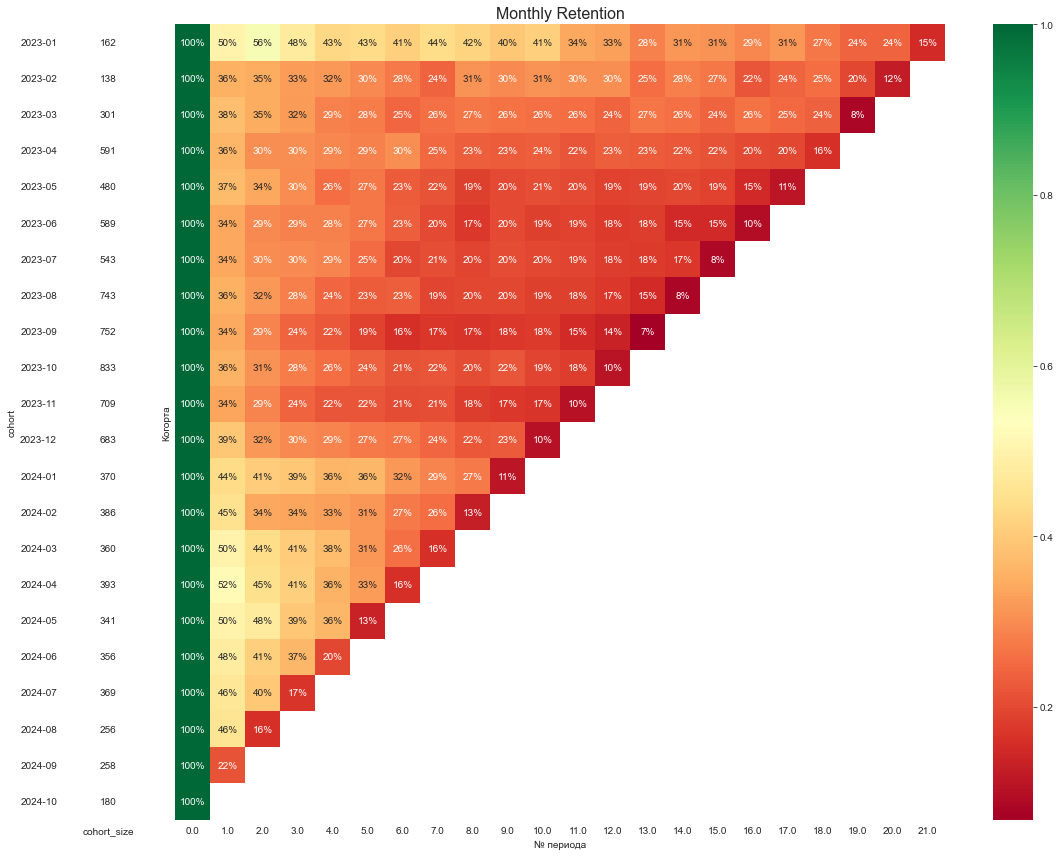

In [ ]:
# Строим тепловую карту когортного анализа
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Тепловая карта для коэффициентов удержания
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.0%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Monthly Retention', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')

    # Тепловая карта для размеров когорт
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()
    plt.show()